# Import the necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

In [2]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [3]:
import cv2
import os
import dlib
import re

# Define a set of variables and functions to be used throughout the notebook

In [4]:
basedir = './dataset_AMLS_22-23/cartoon_set'
images_dir = os.path.join(basedir,'img')
labels_filename = 'labels.csv'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [5]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [6]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [7]:
def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image

In [8]:
# This function was added by myself
def generate_dict_from_df(df, keys_col, values_col):
    zip_ = zip(df[keys_col], df[values_col])
    l = list(zip_)
    d = dict(l)
    return d

In [9]:
def extract_features_labels():
    """
    This funtion extracts the landmarks features for all images in the folder 'dataset/celeba'.
    It also extract the gender label for each image.
    :return:
        landmark_features:  an array containing 68 landmark points for each image in which a face was detected
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image in
                            which a face was detected
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    target_size = None
    #labels_file = open(os.path.join(basedir, labels_filename), 'r')
    #lines = labels_file.readlines()
    labels_df = pd.read_csv(os.path.join(basedir, labels_filename), sep='\t')
    fs_labels = generate_dict_from_df(labels_df, 'file_name', 'face_shape')
    #smiling_labels = generate_dict_from_df(labels_df, 'file_name', 'smiling')
    #gender_labels = {line.split(',')[0] : int(line.split(',')[6]) for line in lines[2:]}
    if os.path.isdir(images_dir):
        all_features = []
        all_fs_labels = []
        #all_smiling_labels = []
        image_files = []
        i = 1
        for img_path in image_paths:
            print(f'Iteration {i} out of {len(image_paths)}')
            #file_name= img_path.split('.')[1].split('/')[-1]
            #file_name = str(img_path).replace('\\\\', 'mmmm')
            new_file_name = re.search('img\\\\(.*)', img_path).group(1)
            #new_img_path = re.search('\\(.*).png', img_path)
            #print(file_name)
            #print(new_file_name)

            # load image
            img = tf.keras.utils.img_to_array(
                tf.keras.utils.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_fs_labels.append(fs_labels[new_file_name])
                #all_smiling_labels.append(smiling_labels[new_file_name])
                image_files.append(new_file_name)
            i += 1

    landmark_features = np.array(all_features)
    fs_labels = (np.array(all_fs_labels) + 1)/2 # simply converts the -1 into 0, so male=0 and female=1
    #smiling_labels = (np.array(all_smiling_labels) + 1)/2
    return landmark_features, fs_labels, image_files

In [14]:
def get_data():
    X, y_fs, image_files = extract_features_labels()
    return X, y_fs, image_files

# Get the features necessary for the training/testing process

In [16]:
X, y_fs, image_files = get_data()

Iteration 1 out of 10000
Iteration 2 out of 10000
Iteration 3 out of 10000
Iteration 4 out of 10000
Iteration 5 out of 10000
Iteration 6 out of 10000
Iteration 7 out of 10000
Iteration 8 out of 10000
Iteration 9 out of 10000
Iteration 10 out of 10000
Iteration 11 out of 10000
Iteration 12 out of 10000
Iteration 13 out of 10000
Iteration 14 out of 10000
Iteration 15 out of 10000
Iteration 16 out of 10000
Iteration 17 out of 10000
Iteration 18 out of 10000
Iteration 19 out of 10000
Iteration 20 out of 10000
Iteration 21 out of 10000
Iteration 22 out of 10000
Iteration 23 out of 10000
Iteration 24 out of 10000
Iteration 25 out of 10000
Iteration 26 out of 10000
Iteration 27 out of 10000
Iteration 28 out of 10000
Iteration 29 out of 10000
Iteration 30 out of 10000
Iteration 31 out of 10000
Iteration 32 out of 10000
Iteration 33 out of 10000
Iteration 34 out of 10000
Iteration 35 out of 10000
Iteration 36 out of 10000
Iteration 37 out of 10000
Iteration 38 out of 10000
Iteration 39 out of 1

Iteration 309 out of 10000
Iteration 310 out of 10000
Iteration 311 out of 10000
Iteration 312 out of 10000
Iteration 313 out of 10000
Iteration 314 out of 10000
Iteration 315 out of 10000
Iteration 316 out of 10000
Iteration 317 out of 10000
Iteration 318 out of 10000
Iteration 319 out of 10000
Iteration 320 out of 10000
Iteration 321 out of 10000
Iteration 322 out of 10000
Iteration 323 out of 10000
Iteration 324 out of 10000
Iteration 325 out of 10000
Iteration 326 out of 10000
Iteration 327 out of 10000
Iteration 328 out of 10000
Iteration 329 out of 10000
Iteration 330 out of 10000
Iteration 331 out of 10000
Iteration 332 out of 10000
Iteration 333 out of 10000
Iteration 334 out of 10000
Iteration 335 out of 10000
Iteration 336 out of 10000
Iteration 337 out of 10000
Iteration 338 out of 10000
Iteration 339 out of 10000
Iteration 340 out of 10000
Iteration 341 out of 10000
Iteration 342 out of 10000
Iteration 343 out of 10000
Iteration 344 out of 10000
Iteration 345 out of 10000
I

Iteration 615 out of 10000
Iteration 616 out of 10000
Iteration 617 out of 10000
Iteration 618 out of 10000
Iteration 619 out of 10000
Iteration 620 out of 10000
Iteration 621 out of 10000
Iteration 622 out of 10000
Iteration 623 out of 10000
Iteration 624 out of 10000
Iteration 625 out of 10000
Iteration 626 out of 10000
Iteration 627 out of 10000
Iteration 628 out of 10000
Iteration 629 out of 10000
Iteration 630 out of 10000
Iteration 631 out of 10000
Iteration 632 out of 10000
Iteration 633 out of 10000
Iteration 634 out of 10000
Iteration 635 out of 10000
Iteration 636 out of 10000
Iteration 637 out of 10000
Iteration 638 out of 10000
Iteration 639 out of 10000
Iteration 640 out of 10000
Iteration 641 out of 10000
Iteration 642 out of 10000
Iteration 643 out of 10000
Iteration 644 out of 10000
Iteration 645 out of 10000
Iteration 646 out of 10000
Iteration 647 out of 10000
Iteration 648 out of 10000
Iteration 649 out of 10000
Iteration 650 out of 10000
Iteration 651 out of 10000
I

Iteration 922 out of 10000
Iteration 923 out of 10000
Iteration 924 out of 10000
Iteration 925 out of 10000
Iteration 926 out of 10000
Iteration 927 out of 10000
Iteration 928 out of 10000
Iteration 929 out of 10000
Iteration 930 out of 10000
Iteration 931 out of 10000
Iteration 932 out of 10000
Iteration 933 out of 10000
Iteration 934 out of 10000
Iteration 935 out of 10000
Iteration 936 out of 10000
Iteration 937 out of 10000
Iteration 938 out of 10000
Iteration 939 out of 10000
Iteration 940 out of 10000
Iteration 941 out of 10000
Iteration 942 out of 10000
Iteration 943 out of 10000
Iteration 944 out of 10000
Iteration 945 out of 10000
Iteration 946 out of 10000
Iteration 947 out of 10000
Iteration 948 out of 10000
Iteration 949 out of 10000
Iteration 950 out of 10000
Iteration 951 out of 10000
Iteration 952 out of 10000
Iteration 953 out of 10000
Iteration 954 out of 10000
Iteration 955 out of 10000
Iteration 956 out of 10000
Iteration 957 out of 10000
Iteration 958 out of 10000
I

Iteration 1221 out of 10000
Iteration 1222 out of 10000
Iteration 1223 out of 10000
Iteration 1224 out of 10000
Iteration 1225 out of 10000
Iteration 1226 out of 10000
Iteration 1227 out of 10000
Iteration 1228 out of 10000
Iteration 1229 out of 10000
Iteration 1230 out of 10000
Iteration 1231 out of 10000
Iteration 1232 out of 10000
Iteration 1233 out of 10000
Iteration 1234 out of 10000
Iteration 1235 out of 10000
Iteration 1236 out of 10000
Iteration 1237 out of 10000
Iteration 1238 out of 10000
Iteration 1239 out of 10000
Iteration 1240 out of 10000
Iteration 1241 out of 10000
Iteration 1242 out of 10000
Iteration 1243 out of 10000
Iteration 1244 out of 10000
Iteration 1245 out of 10000
Iteration 1246 out of 10000
Iteration 1247 out of 10000
Iteration 1248 out of 10000
Iteration 1249 out of 10000
Iteration 1250 out of 10000
Iteration 1251 out of 10000
Iteration 1252 out of 10000
Iteration 1253 out of 10000
Iteration 1254 out of 10000
Iteration 1255 out of 10000
Iteration 1256 out o

Iteration 1515 out of 10000
Iteration 1516 out of 10000
Iteration 1517 out of 10000
Iteration 1518 out of 10000
Iteration 1519 out of 10000
Iteration 1520 out of 10000
Iteration 1521 out of 10000
Iteration 1522 out of 10000
Iteration 1523 out of 10000
Iteration 1524 out of 10000
Iteration 1525 out of 10000
Iteration 1526 out of 10000
Iteration 1527 out of 10000
Iteration 1528 out of 10000
Iteration 1529 out of 10000
Iteration 1530 out of 10000
Iteration 1531 out of 10000
Iteration 1532 out of 10000
Iteration 1533 out of 10000
Iteration 1534 out of 10000
Iteration 1535 out of 10000
Iteration 1536 out of 10000
Iteration 1537 out of 10000
Iteration 1538 out of 10000
Iteration 1539 out of 10000
Iteration 1540 out of 10000
Iteration 1541 out of 10000
Iteration 1542 out of 10000
Iteration 1543 out of 10000
Iteration 1544 out of 10000
Iteration 1545 out of 10000
Iteration 1546 out of 10000
Iteration 1547 out of 10000
Iteration 1548 out of 10000
Iteration 1549 out of 10000
Iteration 1550 out o

Iteration 1808 out of 10000
Iteration 1809 out of 10000
Iteration 1810 out of 10000
Iteration 1811 out of 10000
Iteration 1812 out of 10000
Iteration 1813 out of 10000
Iteration 1814 out of 10000
Iteration 1815 out of 10000
Iteration 1816 out of 10000
Iteration 1817 out of 10000
Iteration 1818 out of 10000
Iteration 1819 out of 10000
Iteration 1820 out of 10000
Iteration 1821 out of 10000
Iteration 1822 out of 10000
Iteration 1823 out of 10000
Iteration 1824 out of 10000
Iteration 1825 out of 10000
Iteration 1826 out of 10000
Iteration 1827 out of 10000
Iteration 1828 out of 10000
Iteration 1829 out of 10000
Iteration 1830 out of 10000
Iteration 1831 out of 10000
Iteration 1832 out of 10000
Iteration 1833 out of 10000
Iteration 1834 out of 10000
Iteration 1835 out of 10000
Iteration 1836 out of 10000
Iteration 1837 out of 10000
Iteration 1838 out of 10000
Iteration 1839 out of 10000
Iteration 1840 out of 10000
Iteration 1841 out of 10000
Iteration 1842 out of 10000
Iteration 1843 out o

Iteration 2103 out of 10000
Iteration 2104 out of 10000
Iteration 2105 out of 10000
Iteration 2106 out of 10000
Iteration 2107 out of 10000
Iteration 2108 out of 10000
Iteration 2109 out of 10000
Iteration 2110 out of 10000
Iteration 2111 out of 10000
Iteration 2112 out of 10000
Iteration 2113 out of 10000
Iteration 2114 out of 10000
Iteration 2115 out of 10000
Iteration 2116 out of 10000
Iteration 2117 out of 10000
Iteration 2118 out of 10000
Iteration 2119 out of 10000
Iteration 2120 out of 10000
Iteration 2121 out of 10000
Iteration 2122 out of 10000
Iteration 2123 out of 10000
Iteration 2124 out of 10000
Iteration 2125 out of 10000
Iteration 2126 out of 10000
Iteration 2127 out of 10000
Iteration 2128 out of 10000
Iteration 2129 out of 10000
Iteration 2130 out of 10000
Iteration 2131 out of 10000
Iteration 2132 out of 10000
Iteration 2133 out of 10000
Iteration 2134 out of 10000
Iteration 2135 out of 10000
Iteration 2136 out of 10000
Iteration 2137 out of 10000
Iteration 2138 out o

Iteration 2396 out of 10000
Iteration 2397 out of 10000
Iteration 2398 out of 10000
Iteration 2399 out of 10000
Iteration 2400 out of 10000
Iteration 2401 out of 10000
Iteration 2402 out of 10000
Iteration 2403 out of 10000
Iteration 2404 out of 10000
Iteration 2405 out of 10000
Iteration 2406 out of 10000
Iteration 2407 out of 10000
Iteration 2408 out of 10000
Iteration 2409 out of 10000
Iteration 2410 out of 10000
Iteration 2411 out of 10000
Iteration 2412 out of 10000
Iteration 2413 out of 10000
Iteration 2414 out of 10000
Iteration 2415 out of 10000
Iteration 2416 out of 10000
Iteration 2417 out of 10000
Iteration 2418 out of 10000
Iteration 2419 out of 10000
Iteration 2420 out of 10000
Iteration 2421 out of 10000
Iteration 2422 out of 10000
Iteration 2423 out of 10000
Iteration 2424 out of 10000
Iteration 2425 out of 10000
Iteration 2426 out of 10000
Iteration 2427 out of 10000
Iteration 2428 out of 10000
Iteration 2429 out of 10000
Iteration 2430 out of 10000
Iteration 2431 out o

Iteration 2691 out of 10000
Iteration 2692 out of 10000
Iteration 2693 out of 10000
Iteration 2694 out of 10000
Iteration 2695 out of 10000
Iteration 2696 out of 10000
Iteration 2697 out of 10000
Iteration 2698 out of 10000
Iteration 2699 out of 10000
Iteration 2700 out of 10000
Iteration 2701 out of 10000
Iteration 2702 out of 10000
Iteration 2703 out of 10000
Iteration 2704 out of 10000
Iteration 2705 out of 10000
Iteration 2706 out of 10000
Iteration 2707 out of 10000
Iteration 2708 out of 10000
Iteration 2709 out of 10000
Iteration 2710 out of 10000
Iteration 2711 out of 10000
Iteration 2712 out of 10000
Iteration 2713 out of 10000
Iteration 2714 out of 10000
Iteration 2715 out of 10000
Iteration 2716 out of 10000
Iteration 2717 out of 10000
Iteration 2718 out of 10000
Iteration 2719 out of 10000
Iteration 2720 out of 10000
Iteration 2721 out of 10000
Iteration 2722 out of 10000
Iteration 2723 out of 10000
Iteration 2724 out of 10000
Iteration 2725 out of 10000
Iteration 2726 out o

Iteration 2985 out of 10000
Iteration 2986 out of 10000
Iteration 2987 out of 10000
Iteration 2988 out of 10000
Iteration 2989 out of 10000
Iteration 2990 out of 10000
Iteration 2991 out of 10000
Iteration 2992 out of 10000
Iteration 2993 out of 10000
Iteration 2994 out of 10000
Iteration 2995 out of 10000
Iteration 2996 out of 10000
Iteration 2997 out of 10000
Iteration 2998 out of 10000
Iteration 2999 out of 10000
Iteration 3000 out of 10000
Iteration 3001 out of 10000
Iteration 3002 out of 10000
Iteration 3003 out of 10000
Iteration 3004 out of 10000
Iteration 3005 out of 10000
Iteration 3006 out of 10000
Iteration 3007 out of 10000
Iteration 3008 out of 10000
Iteration 3009 out of 10000
Iteration 3010 out of 10000
Iteration 3011 out of 10000
Iteration 3012 out of 10000
Iteration 3013 out of 10000
Iteration 3014 out of 10000
Iteration 3015 out of 10000
Iteration 3016 out of 10000
Iteration 3017 out of 10000
Iteration 3018 out of 10000
Iteration 3019 out of 10000
Iteration 3020 out o

Iteration 3279 out of 10000
Iteration 3280 out of 10000
Iteration 3281 out of 10000
Iteration 3282 out of 10000
Iteration 3283 out of 10000
Iteration 3284 out of 10000
Iteration 3285 out of 10000
Iteration 3286 out of 10000
Iteration 3287 out of 10000
Iteration 3288 out of 10000
Iteration 3289 out of 10000
Iteration 3290 out of 10000
Iteration 3291 out of 10000
Iteration 3292 out of 10000
Iteration 3293 out of 10000
Iteration 3294 out of 10000
Iteration 3295 out of 10000
Iteration 3296 out of 10000
Iteration 3297 out of 10000
Iteration 3298 out of 10000
Iteration 3299 out of 10000
Iteration 3300 out of 10000
Iteration 3301 out of 10000
Iteration 3302 out of 10000
Iteration 3303 out of 10000
Iteration 3304 out of 10000
Iteration 3305 out of 10000
Iteration 3306 out of 10000
Iteration 3307 out of 10000
Iteration 3308 out of 10000
Iteration 3309 out of 10000
Iteration 3310 out of 10000
Iteration 3311 out of 10000
Iteration 3312 out of 10000
Iteration 3313 out of 10000
Iteration 3314 out o

Iteration 3574 out of 10000
Iteration 3575 out of 10000
Iteration 3576 out of 10000
Iteration 3577 out of 10000
Iteration 3578 out of 10000
Iteration 3579 out of 10000
Iteration 3580 out of 10000
Iteration 3581 out of 10000
Iteration 3582 out of 10000
Iteration 3583 out of 10000
Iteration 3584 out of 10000
Iteration 3585 out of 10000
Iteration 3586 out of 10000
Iteration 3587 out of 10000
Iteration 3588 out of 10000
Iteration 3589 out of 10000
Iteration 3590 out of 10000
Iteration 3591 out of 10000
Iteration 3592 out of 10000
Iteration 3593 out of 10000
Iteration 3594 out of 10000
Iteration 3595 out of 10000
Iteration 3596 out of 10000
Iteration 3597 out of 10000
Iteration 3598 out of 10000
Iteration 3599 out of 10000
Iteration 3600 out of 10000
Iteration 3601 out of 10000
Iteration 3602 out of 10000
Iteration 3603 out of 10000
Iteration 3604 out of 10000
Iteration 3605 out of 10000
Iteration 3606 out of 10000
Iteration 3607 out of 10000
Iteration 3608 out of 10000
Iteration 3609 out o

Iteration 3867 out of 10000
Iteration 3868 out of 10000
Iteration 3869 out of 10000
Iteration 3870 out of 10000
Iteration 3871 out of 10000
Iteration 3872 out of 10000
Iteration 3873 out of 10000
Iteration 3874 out of 10000
Iteration 3875 out of 10000
Iteration 3876 out of 10000
Iteration 3877 out of 10000
Iteration 3878 out of 10000
Iteration 3879 out of 10000
Iteration 3880 out of 10000
Iteration 3881 out of 10000
Iteration 3882 out of 10000
Iteration 3883 out of 10000
Iteration 3884 out of 10000
Iteration 3885 out of 10000
Iteration 3886 out of 10000
Iteration 3887 out of 10000
Iteration 3888 out of 10000
Iteration 3889 out of 10000
Iteration 3890 out of 10000
Iteration 3891 out of 10000
Iteration 3892 out of 10000
Iteration 3893 out of 10000
Iteration 3894 out of 10000
Iteration 3895 out of 10000
Iteration 3896 out of 10000
Iteration 3897 out of 10000
Iteration 3898 out of 10000
Iteration 3899 out of 10000
Iteration 3900 out of 10000
Iteration 3901 out of 10000
Iteration 3902 out o

Iteration 4161 out of 10000
Iteration 4162 out of 10000
Iteration 4163 out of 10000
Iteration 4164 out of 10000
Iteration 4165 out of 10000
Iteration 4166 out of 10000
Iteration 4167 out of 10000
Iteration 4168 out of 10000
Iteration 4169 out of 10000
Iteration 4170 out of 10000
Iteration 4171 out of 10000
Iteration 4172 out of 10000
Iteration 4173 out of 10000
Iteration 4174 out of 10000
Iteration 4175 out of 10000
Iteration 4176 out of 10000
Iteration 4177 out of 10000
Iteration 4178 out of 10000
Iteration 4179 out of 10000
Iteration 4180 out of 10000
Iteration 4181 out of 10000
Iteration 4182 out of 10000
Iteration 4183 out of 10000
Iteration 4184 out of 10000
Iteration 4185 out of 10000
Iteration 4186 out of 10000
Iteration 4187 out of 10000
Iteration 4188 out of 10000
Iteration 4189 out of 10000
Iteration 4190 out of 10000
Iteration 4191 out of 10000
Iteration 4192 out of 10000
Iteration 4193 out of 10000
Iteration 4194 out of 10000
Iteration 4195 out of 10000
Iteration 4196 out o

Iteration 4454 out of 10000
Iteration 4455 out of 10000
Iteration 4456 out of 10000
Iteration 4457 out of 10000
Iteration 4458 out of 10000
Iteration 4459 out of 10000
Iteration 4460 out of 10000
Iteration 4461 out of 10000
Iteration 4462 out of 10000
Iteration 4463 out of 10000
Iteration 4464 out of 10000
Iteration 4465 out of 10000
Iteration 4466 out of 10000
Iteration 4467 out of 10000
Iteration 4468 out of 10000
Iteration 4469 out of 10000
Iteration 4470 out of 10000
Iteration 4471 out of 10000
Iteration 4472 out of 10000
Iteration 4473 out of 10000
Iteration 4474 out of 10000
Iteration 4475 out of 10000
Iteration 4476 out of 10000
Iteration 4477 out of 10000
Iteration 4478 out of 10000
Iteration 4479 out of 10000
Iteration 4480 out of 10000
Iteration 4481 out of 10000
Iteration 4482 out of 10000
Iteration 4483 out of 10000
Iteration 4484 out of 10000
Iteration 4485 out of 10000
Iteration 4486 out of 10000
Iteration 4487 out of 10000
Iteration 4488 out of 10000
Iteration 4489 out o

Iteration 4748 out of 10000
Iteration 4749 out of 10000
Iteration 4750 out of 10000
Iteration 4751 out of 10000
Iteration 4752 out of 10000
Iteration 4753 out of 10000
Iteration 4754 out of 10000
Iteration 4755 out of 10000
Iteration 4756 out of 10000
Iteration 4757 out of 10000
Iteration 4758 out of 10000
Iteration 4759 out of 10000
Iteration 4760 out of 10000
Iteration 4761 out of 10000
Iteration 4762 out of 10000
Iteration 4763 out of 10000
Iteration 4764 out of 10000
Iteration 4765 out of 10000
Iteration 4766 out of 10000
Iteration 4767 out of 10000
Iteration 4768 out of 10000
Iteration 4769 out of 10000
Iteration 4770 out of 10000
Iteration 4771 out of 10000
Iteration 4772 out of 10000
Iteration 4773 out of 10000
Iteration 4774 out of 10000
Iteration 4775 out of 10000
Iteration 4776 out of 10000
Iteration 4777 out of 10000
Iteration 4778 out of 10000
Iteration 4779 out of 10000
Iteration 4780 out of 10000
Iteration 4781 out of 10000
Iteration 4782 out of 10000
Iteration 4783 out o

Iteration 5042 out of 10000
Iteration 5043 out of 10000
Iteration 5044 out of 10000
Iteration 5045 out of 10000
Iteration 5046 out of 10000
Iteration 5047 out of 10000
Iteration 5048 out of 10000
Iteration 5049 out of 10000
Iteration 5050 out of 10000
Iteration 5051 out of 10000
Iteration 5052 out of 10000
Iteration 5053 out of 10000
Iteration 5054 out of 10000
Iteration 5055 out of 10000
Iteration 5056 out of 10000
Iteration 5057 out of 10000
Iteration 5058 out of 10000
Iteration 5059 out of 10000
Iteration 5060 out of 10000
Iteration 5061 out of 10000
Iteration 5062 out of 10000
Iteration 5063 out of 10000
Iteration 5064 out of 10000
Iteration 5065 out of 10000
Iteration 5066 out of 10000
Iteration 5067 out of 10000
Iteration 5068 out of 10000
Iteration 5069 out of 10000
Iteration 5070 out of 10000
Iteration 5071 out of 10000
Iteration 5072 out of 10000
Iteration 5073 out of 10000
Iteration 5074 out of 10000
Iteration 5075 out of 10000
Iteration 5076 out of 10000
Iteration 5077 out o

Iteration 5336 out of 10000
Iteration 5337 out of 10000
Iteration 5338 out of 10000
Iteration 5339 out of 10000
Iteration 5340 out of 10000
Iteration 5341 out of 10000
Iteration 5342 out of 10000
Iteration 5343 out of 10000
Iteration 5344 out of 10000
Iteration 5345 out of 10000
Iteration 5346 out of 10000
Iteration 5347 out of 10000
Iteration 5348 out of 10000
Iteration 5349 out of 10000
Iteration 5350 out of 10000
Iteration 5351 out of 10000
Iteration 5352 out of 10000
Iteration 5353 out of 10000
Iteration 5354 out of 10000
Iteration 5355 out of 10000
Iteration 5356 out of 10000
Iteration 5357 out of 10000
Iteration 5358 out of 10000
Iteration 5359 out of 10000
Iteration 5360 out of 10000
Iteration 5361 out of 10000
Iteration 5362 out of 10000
Iteration 5363 out of 10000
Iteration 5364 out of 10000
Iteration 5365 out of 10000
Iteration 5366 out of 10000
Iteration 5367 out of 10000
Iteration 5368 out of 10000
Iteration 5369 out of 10000
Iteration 5370 out of 10000
Iteration 5371 out o

Iteration 5631 out of 10000
Iteration 5632 out of 10000
Iteration 5633 out of 10000
Iteration 5634 out of 10000
Iteration 5635 out of 10000
Iteration 5636 out of 10000
Iteration 5637 out of 10000
Iteration 5638 out of 10000
Iteration 5639 out of 10000
Iteration 5640 out of 10000
Iteration 5641 out of 10000
Iteration 5642 out of 10000
Iteration 5643 out of 10000
Iteration 5644 out of 10000
Iteration 5645 out of 10000
Iteration 5646 out of 10000
Iteration 5647 out of 10000
Iteration 5648 out of 10000
Iteration 5649 out of 10000
Iteration 5650 out of 10000
Iteration 5651 out of 10000
Iteration 5652 out of 10000
Iteration 5653 out of 10000
Iteration 5654 out of 10000
Iteration 5655 out of 10000
Iteration 5656 out of 10000
Iteration 5657 out of 10000
Iteration 5658 out of 10000
Iteration 5659 out of 10000
Iteration 5660 out of 10000
Iteration 5661 out of 10000
Iteration 5662 out of 10000
Iteration 5663 out of 10000
Iteration 5664 out of 10000
Iteration 5665 out of 10000
Iteration 5666 out o

Iteration 5926 out of 10000
Iteration 5927 out of 10000
Iteration 5928 out of 10000
Iteration 5929 out of 10000
Iteration 5930 out of 10000
Iteration 5931 out of 10000
Iteration 5932 out of 10000
Iteration 5933 out of 10000
Iteration 5934 out of 10000
Iteration 5935 out of 10000
Iteration 5936 out of 10000
Iteration 5937 out of 10000
Iteration 5938 out of 10000
Iteration 5939 out of 10000
Iteration 5940 out of 10000
Iteration 5941 out of 10000
Iteration 5942 out of 10000
Iteration 5943 out of 10000
Iteration 5944 out of 10000
Iteration 5945 out of 10000
Iteration 5946 out of 10000
Iteration 5947 out of 10000
Iteration 5948 out of 10000
Iteration 5949 out of 10000
Iteration 5950 out of 10000
Iteration 5951 out of 10000
Iteration 5952 out of 10000
Iteration 5953 out of 10000
Iteration 5954 out of 10000
Iteration 5955 out of 10000
Iteration 5956 out of 10000
Iteration 5957 out of 10000
Iteration 5958 out of 10000
Iteration 5959 out of 10000
Iteration 5960 out of 10000
Iteration 5961 out o

Iteration 6221 out of 10000
Iteration 6222 out of 10000
Iteration 6223 out of 10000
Iteration 6224 out of 10000
Iteration 6225 out of 10000
Iteration 6226 out of 10000
Iteration 6227 out of 10000
Iteration 6228 out of 10000
Iteration 6229 out of 10000
Iteration 6230 out of 10000
Iteration 6231 out of 10000
Iteration 6232 out of 10000
Iteration 6233 out of 10000
Iteration 6234 out of 10000
Iteration 6235 out of 10000
Iteration 6236 out of 10000
Iteration 6237 out of 10000
Iteration 6238 out of 10000
Iteration 6239 out of 10000
Iteration 6240 out of 10000
Iteration 6241 out of 10000
Iteration 6242 out of 10000
Iteration 6243 out of 10000
Iteration 6244 out of 10000
Iteration 6245 out of 10000
Iteration 6246 out of 10000
Iteration 6247 out of 10000
Iteration 6248 out of 10000
Iteration 6249 out of 10000
Iteration 6250 out of 10000
Iteration 6251 out of 10000
Iteration 6252 out of 10000
Iteration 6253 out of 10000
Iteration 6254 out of 10000
Iteration 6255 out of 10000
Iteration 6256 out o

Iteration 6515 out of 10000
Iteration 6516 out of 10000
Iteration 6517 out of 10000
Iteration 6518 out of 10000
Iteration 6519 out of 10000
Iteration 6520 out of 10000
Iteration 6521 out of 10000
Iteration 6522 out of 10000
Iteration 6523 out of 10000
Iteration 6524 out of 10000
Iteration 6525 out of 10000
Iteration 6526 out of 10000
Iteration 6527 out of 10000
Iteration 6528 out of 10000
Iteration 6529 out of 10000
Iteration 6530 out of 10000
Iteration 6531 out of 10000
Iteration 6532 out of 10000
Iteration 6533 out of 10000
Iteration 6534 out of 10000
Iteration 6535 out of 10000
Iteration 6536 out of 10000
Iteration 6537 out of 10000
Iteration 6538 out of 10000
Iteration 6539 out of 10000
Iteration 6540 out of 10000
Iteration 6541 out of 10000
Iteration 6542 out of 10000
Iteration 6543 out of 10000
Iteration 6544 out of 10000
Iteration 6545 out of 10000
Iteration 6546 out of 10000
Iteration 6547 out of 10000
Iteration 6548 out of 10000
Iteration 6549 out of 10000
Iteration 6550 out o

Iteration 6810 out of 10000
Iteration 6811 out of 10000
Iteration 6812 out of 10000
Iteration 6813 out of 10000
Iteration 6814 out of 10000
Iteration 6815 out of 10000
Iteration 6816 out of 10000
Iteration 6817 out of 10000
Iteration 6818 out of 10000
Iteration 6819 out of 10000
Iteration 6820 out of 10000
Iteration 6821 out of 10000
Iteration 6822 out of 10000
Iteration 6823 out of 10000
Iteration 6824 out of 10000
Iteration 6825 out of 10000
Iteration 6826 out of 10000
Iteration 6827 out of 10000
Iteration 6828 out of 10000
Iteration 6829 out of 10000
Iteration 6830 out of 10000
Iteration 6831 out of 10000
Iteration 6832 out of 10000
Iteration 6833 out of 10000
Iteration 6834 out of 10000
Iteration 6835 out of 10000
Iteration 6836 out of 10000
Iteration 6837 out of 10000
Iteration 6838 out of 10000
Iteration 6839 out of 10000
Iteration 6840 out of 10000
Iteration 6841 out of 10000
Iteration 6842 out of 10000
Iteration 6843 out of 10000
Iteration 6844 out of 10000
Iteration 6845 out o

Iteration 7103 out of 10000
Iteration 7104 out of 10000
Iteration 7105 out of 10000
Iteration 7106 out of 10000
Iteration 7107 out of 10000
Iteration 7108 out of 10000
Iteration 7109 out of 10000
Iteration 7110 out of 10000
Iteration 7111 out of 10000
Iteration 7112 out of 10000
Iteration 7113 out of 10000
Iteration 7114 out of 10000
Iteration 7115 out of 10000
Iteration 7116 out of 10000
Iteration 7117 out of 10000
Iteration 7118 out of 10000
Iteration 7119 out of 10000
Iteration 7120 out of 10000
Iteration 7121 out of 10000
Iteration 7122 out of 10000
Iteration 7123 out of 10000
Iteration 7124 out of 10000
Iteration 7125 out of 10000
Iteration 7126 out of 10000
Iteration 7127 out of 10000
Iteration 7128 out of 10000
Iteration 7129 out of 10000
Iteration 7130 out of 10000
Iteration 7131 out of 10000
Iteration 7132 out of 10000
Iteration 7133 out of 10000
Iteration 7134 out of 10000
Iteration 7135 out of 10000
Iteration 7136 out of 10000
Iteration 7137 out of 10000
Iteration 7138 out o

Iteration 7398 out of 10000
Iteration 7399 out of 10000
Iteration 7400 out of 10000
Iteration 7401 out of 10000
Iteration 7402 out of 10000
Iteration 7403 out of 10000
Iteration 7404 out of 10000
Iteration 7405 out of 10000
Iteration 7406 out of 10000
Iteration 7407 out of 10000
Iteration 7408 out of 10000
Iteration 7409 out of 10000
Iteration 7410 out of 10000
Iteration 7411 out of 10000
Iteration 7412 out of 10000
Iteration 7413 out of 10000
Iteration 7414 out of 10000
Iteration 7415 out of 10000
Iteration 7416 out of 10000
Iteration 7417 out of 10000
Iteration 7418 out of 10000
Iteration 7419 out of 10000
Iteration 7420 out of 10000
Iteration 7421 out of 10000
Iteration 7422 out of 10000
Iteration 7423 out of 10000
Iteration 7424 out of 10000
Iteration 7425 out of 10000
Iteration 7426 out of 10000
Iteration 7427 out of 10000
Iteration 7428 out of 10000
Iteration 7429 out of 10000
Iteration 7430 out of 10000
Iteration 7431 out of 10000
Iteration 7432 out of 10000
Iteration 7433 out o

Iteration 7692 out of 10000
Iteration 7693 out of 10000
Iteration 7694 out of 10000
Iteration 7695 out of 10000
Iteration 7696 out of 10000
Iteration 7697 out of 10000
Iteration 7698 out of 10000
Iteration 7699 out of 10000
Iteration 7700 out of 10000
Iteration 7701 out of 10000
Iteration 7702 out of 10000
Iteration 7703 out of 10000
Iteration 7704 out of 10000
Iteration 7705 out of 10000
Iteration 7706 out of 10000
Iteration 7707 out of 10000
Iteration 7708 out of 10000
Iteration 7709 out of 10000
Iteration 7710 out of 10000
Iteration 7711 out of 10000
Iteration 7712 out of 10000
Iteration 7713 out of 10000
Iteration 7714 out of 10000
Iteration 7715 out of 10000
Iteration 7716 out of 10000
Iteration 7717 out of 10000
Iteration 7718 out of 10000
Iteration 7719 out of 10000
Iteration 7720 out of 10000
Iteration 7721 out of 10000
Iteration 7722 out of 10000
Iteration 7723 out of 10000
Iteration 7724 out of 10000
Iteration 7725 out of 10000
Iteration 7726 out of 10000
Iteration 7727 out o

Iteration 7987 out of 10000
Iteration 7988 out of 10000
Iteration 7989 out of 10000
Iteration 7990 out of 10000
Iteration 7991 out of 10000
Iteration 7992 out of 10000
Iteration 7993 out of 10000
Iteration 7994 out of 10000
Iteration 7995 out of 10000
Iteration 7996 out of 10000
Iteration 7997 out of 10000
Iteration 7998 out of 10000
Iteration 7999 out of 10000
Iteration 8000 out of 10000
Iteration 8001 out of 10000
Iteration 8002 out of 10000
Iteration 8003 out of 10000
Iteration 8004 out of 10000
Iteration 8005 out of 10000
Iteration 8006 out of 10000
Iteration 8007 out of 10000
Iteration 8008 out of 10000
Iteration 8009 out of 10000
Iteration 8010 out of 10000
Iteration 8011 out of 10000
Iteration 8012 out of 10000
Iteration 8013 out of 10000
Iteration 8014 out of 10000
Iteration 8015 out of 10000
Iteration 8016 out of 10000
Iteration 8017 out of 10000
Iteration 8018 out of 10000
Iteration 8019 out of 10000
Iteration 8020 out of 10000
Iteration 8021 out of 10000
Iteration 8022 out o

Iteration 8280 out of 10000
Iteration 8281 out of 10000
Iteration 8282 out of 10000
Iteration 8283 out of 10000
Iteration 8284 out of 10000
Iteration 8285 out of 10000
Iteration 8286 out of 10000
Iteration 8287 out of 10000
Iteration 8288 out of 10000
Iteration 8289 out of 10000
Iteration 8290 out of 10000
Iteration 8291 out of 10000
Iteration 8292 out of 10000
Iteration 8293 out of 10000
Iteration 8294 out of 10000
Iteration 8295 out of 10000
Iteration 8296 out of 10000
Iteration 8297 out of 10000
Iteration 8298 out of 10000
Iteration 8299 out of 10000
Iteration 8300 out of 10000
Iteration 8301 out of 10000
Iteration 8302 out of 10000
Iteration 8303 out of 10000
Iteration 8304 out of 10000
Iteration 8305 out of 10000
Iteration 8306 out of 10000
Iteration 8307 out of 10000
Iteration 8308 out of 10000
Iteration 8309 out of 10000
Iteration 8310 out of 10000
Iteration 8311 out of 10000
Iteration 8312 out of 10000
Iteration 8313 out of 10000
Iteration 8314 out of 10000
Iteration 8315 out o

Iteration 8573 out of 10000
Iteration 8574 out of 10000
Iteration 8575 out of 10000
Iteration 8576 out of 10000
Iteration 8577 out of 10000
Iteration 8578 out of 10000
Iteration 8579 out of 10000
Iteration 8580 out of 10000
Iteration 8581 out of 10000
Iteration 8582 out of 10000
Iteration 8583 out of 10000
Iteration 8584 out of 10000
Iteration 8585 out of 10000
Iteration 8586 out of 10000
Iteration 8587 out of 10000
Iteration 8588 out of 10000
Iteration 8589 out of 10000
Iteration 8590 out of 10000
Iteration 8591 out of 10000
Iteration 8592 out of 10000
Iteration 8593 out of 10000
Iteration 8594 out of 10000
Iteration 8595 out of 10000
Iteration 8596 out of 10000
Iteration 8597 out of 10000
Iteration 8598 out of 10000
Iteration 8599 out of 10000
Iteration 8600 out of 10000
Iteration 8601 out of 10000
Iteration 8602 out of 10000
Iteration 8603 out of 10000
Iteration 8604 out of 10000
Iteration 8605 out of 10000
Iteration 8606 out of 10000
Iteration 8607 out of 10000
Iteration 8608 out o

Iteration 8866 out of 10000
Iteration 8867 out of 10000
Iteration 8868 out of 10000
Iteration 8869 out of 10000
Iteration 8870 out of 10000
Iteration 8871 out of 10000
Iteration 8872 out of 10000
Iteration 8873 out of 10000
Iteration 8874 out of 10000
Iteration 8875 out of 10000
Iteration 8876 out of 10000
Iteration 8877 out of 10000
Iteration 8878 out of 10000
Iteration 8879 out of 10000
Iteration 8880 out of 10000
Iteration 8881 out of 10000
Iteration 8882 out of 10000
Iteration 8883 out of 10000
Iteration 8884 out of 10000
Iteration 8885 out of 10000
Iteration 8886 out of 10000
Iteration 8887 out of 10000
Iteration 8888 out of 10000
Iteration 8889 out of 10000
Iteration 8890 out of 10000
Iteration 8891 out of 10000
Iteration 8892 out of 10000
Iteration 8893 out of 10000
Iteration 8894 out of 10000
Iteration 8895 out of 10000
Iteration 8896 out of 10000
Iteration 8897 out of 10000
Iteration 8898 out of 10000
Iteration 8899 out of 10000
Iteration 8900 out of 10000
Iteration 8901 out o

Iteration 9161 out of 10000
Iteration 9162 out of 10000
Iteration 9163 out of 10000
Iteration 9164 out of 10000
Iteration 9165 out of 10000
Iteration 9166 out of 10000
Iteration 9167 out of 10000
Iteration 9168 out of 10000
Iteration 9169 out of 10000
Iteration 9170 out of 10000
Iteration 9171 out of 10000
Iteration 9172 out of 10000
Iteration 9173 out of 10000
Iteration 9174 out of 10000
Iteration 9175 out of 10000
Iteration 9176 out of 10000
Iteration 9177 out of 10000
Iteration 9178 out of 10000
Iteration 9179 out of 10000
Iteration 9180 out of 10000
Iteration 9181 out of 10000
Iteration 9182 out of 10000
Iteration 9183 out of 10000
Iteration 9184 out of 10000
Iteration 9185 out of 10000
Iteration 9186 out of 10000
Iteration 9187 out of 10000
Iteration 9188 out of 10000
Iteration 9189 out of 10000
Iteration 9190 out of 10000
Iteration 9191 out of 10000
Iteration 9192 out of 10000
Iteration 9193 out of 10000
Iteration 9194 out of 10000
Iteration 9195 out of 10000
Iteration 9196 out o

Iteration 9455 out of 10000
Iteration 9456 out of 10000
Iteration 9457 out of 10000
Iteration 9458 out of 10000
Iteration 9459 out of 10000
Iteration 9460 out of 10000
Iteration 9461 out of 10000
Iteration 9462 out of 10000
Iteration 9463 out of 10000
Iteration 9464 out of 10000
Iteration 9465 out of 10000
Iteration 9466 out of 10000
Iteration 9467 out of 10000
Iteration 9468 out of 10000
Iteration 9469 out of 10000
Iteration 9470 out of 10000
Iteration 9471 out of 10000
Iteration 9472 out of 10000
Iteration 9473 out of 10000
Iteration 9474 out of 10000
Iteration 9475 out of 10000
Iteration 9476 out of 10000
Iteration 9477 out of 10000
Iteration 9478 out of 10000
Iteration 9479 out of 10000
Iteration 9480 out of 10000
Iteration 9481 out of 10000
Iteration 9482 out of 10000
Iteration 9483 out of 10000
Iteration 9484 out of 10000
Iteration 9485 out of 10000
Iteration 9486 out of 10000
Iteration 9487 out of 10000
Iteration 9488 out of 10000
Iteration 9489 out of 10000
Iteration 9490 out o

Iteration 9749 out of 10000
Iteration 9750 out of 10000
Iteration 9751 out of 10000
Iteration 9752 out of 10000
Iteration 9753 out of 10000
Iteration 9754 out of 10000
Iteration 9755 out of 10000
Iteration 9756 out of 10000
Iteration 9757 out of 10000
Iteration 9758 out of 10000
Iteration 9759 out of 10000
Iteration 9760 out of 10000
Iteration 9761 out of 10000
Iteration 9762 out of 10000
Iteration 9763 out of 10000
Iteration 9764 out of 10000
Iteration 9765 out of 10000
Iteration 9766 out of 10000
Iteration 9767 out of 10000
Iteration 9768 out of 10000
Iteration 9769 out of 10000
Iteration 9770 out of 10000
Iteration 9771 out of 10000
Iteration 9772 out of 10000
Iteration 9773 out of 10000
Iteration 9774 out of 10000
Iteration 9775 out of 10000
Iteration 9776 out of 10000
Iteration 9777 out of 10000
Iteration 9778 out of 10000
Iteration 9779 out of 10000
Iteration 9780 out of 10000
Iteration 9781 out of 10000
Iteration 9782 out of 10000
Iteration 9783 out of 10000
Iteration 9784 out o

This process took approximately 3 minutes. Therefore, I will now store the obtained variables to ensure that I don't need to run this process every time I work on this dataset.

In [21]:
%store X

Stored 'X' (ndarray)


In [22]:
%store y_fs

Stored 'y_fs' (ndarray)


In [23]:
%store image_files

Stored 'image_files' (list)


As the code for extracting features was copied from the code we were given for the lab, I need to modify y_fs (as the code was intended for a binary classification).

In [16]:
y_fs_modified = 2*y_fs - 1

# Let's scale the image arrays

In [23]:
from sklearn.preprocessing import StandardScaler  # Maybe Scaling is not Necessary
sc = StandardScaler()
training_images_scaled = sc.fit_transform(training_images.reshape((6600, 136)))

In [24]:
training_images_scaled

array([[-2.15683559,  2.59181977, -2.42743184, ..., -0.03187709,
         0.56325634,  0.24304642],
       [ 0.35559821,  0.09661059,  0.45243337, ...,  0.75965326,
         0.56325634,  0.71535175],
       [-0.64937531, -0.63115875, -0.80750766, ...,  0.91795933,
        -0.61739955,  0.87278686],
       ...,
       [-0.31438414, -0.3192576 , -0.26753293, ...,  0.28473505,
         1.35036027,  0.24304642],
       [ 1.02558055,  1.55214928,  1.17239967, ...,  0.44304112,
        -0.61739955,  0.40048153],
       [ 0.18810262,  0.51247879,  0.45243337, ...,  0.44304112,
        -0.22384759,  0.24304642]])

In [26]:
test_images_scaled = sc.transform(test_images.reshape((1594, 136)))

In [28]:
training_labels_fs = y_fs_modified[:6600]; test_labels_fs = y_fs_modified[6600:]

# Let's train a simple Neural Network

In [30]:
# This model was extracted from Project 6.ipynb (online course)
classifier = tf.keras.models.Sequential()
classifier.add(tf.keras.layers.Dense(units = 400, activation = 'relu', input_shape = (136,)))
classifier.add(tf.keras.layers.Dropout(0.2)) # Drop some neurons, along with their weights, to avoid overfitting the data

classifier.add(tf.keras.layers.Dense(units = 400, activation = 'relu'))
classifier.add(tf.keras.layers.Dropout(0.2))

classifier.add(tf.keras.layers.Dense(units = 5, activation = 'sigmoid'))

In [31]:
classifier.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [32]:
epochs_hist = classifier.fit(training_images_scaled, training_labels_fs, epochs = 100)

Epoch 1/100
207/207 [==============================] - 3s 6ms/step - loss: 1.2250 - accuracy: 0.5383
Epoch 2/100
207/207 [==============================] - 1s 7ms/step - loss: 0.9475 - accuracy: 0.6536
Epoch 3/100
207/207 [==============================] - 1s 7ms/step - loss: 0.8162 - accuracy: 0.7032
Epoch 4/100
207/207 [==============================] - 2s 7ms/step - loss: 0.7502 - accuracy: 0.7289
Epoch 5/100
207/207 [==============================] - 1s 6ms/step - loss: 0.7136 - accuracy: 0.7367
Epoch 6/100
207/207 [==============================] - 2s 8ms/step - loss: 0.6731 - accuracy: 0.7453
Epoch 7/100
207/207 [==============================] - 2s 7ms/step - loss: 0.6354 - accuracy: 0.7602
Epoch 8/100
207/207 [==============================] - 2s 8ms/step - loss: 0.6029 - accuracy: 0.7682
Epoch 9/100
207/207 [==============================] - 1s 7ms/step - loss: 0.5850 - accuracy: 0.7798
Epoch 10/100
207/207 [==============================] - 2s 8ms/step - loss: 0.5611 - accura

# Get the test Accuracy

In [33]:
predicted_test_labels = classifier.predict(test_images_scaled)

50/50 [==============================] - 0s 2ms/step


In [34]:
predicted_test_labels

array([[4.7973652e-09, 2.8038718e-09, 3.0411934e-06, 8.3009279e-01,
        1.0000000e+00],
       [1.0000000e+00, 2.1178545e-03, 7.0142487e-17, 2.5953273e-11,
        4.6433691e-08],
       [9.9573511e-01, 9.9581146e-01, 2.0134120e-08, 2.2011093e-04,
        2.2386607e-02],
       ...,
       [1.8036123e-01, 9.6682388e-06, 7.8428495e-01, 6.2739974e-01,
        2.3173562e-03],
       [1.4136480e-06, 2.6049481e-06, 9.9999905e-01, 9.8459059e-01,
        6.1977126e-08],
       [7.5401333e-03, 1.1401387e-03, 9.9997759e-01, 1.7371179e-01,
        1.8972391e-06]], dtype=float32)

In [36]:
evaluation = classifier.evaluate(test_images_scaled, test_labels_fs)

50/50 [==============================] - 0s 3ms/step - loss: 1.1810 - accuracy: 0.7685


<AxesSubplot:>

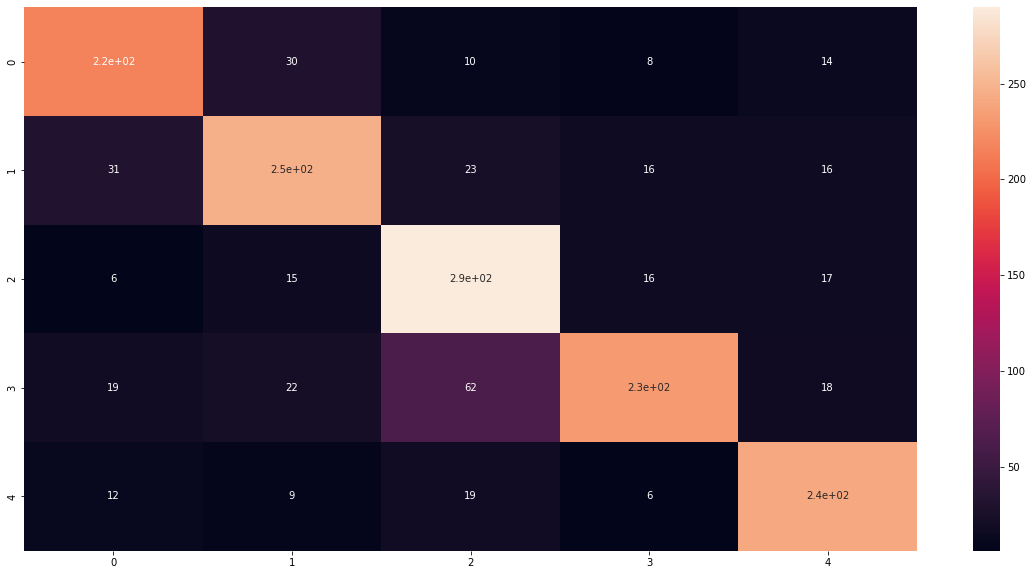

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels_fs, pred_test_labels_individual)
plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot = True)